## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import os
import peakutils
from sklearn.mixture import GaussianMixture as GMM


from ourfunctions_v3 import clean_nan_samples, remove_noise, interpolate_spectra, spectrum_in_bins_3

## Important Preprocessing parameters

In [2]:
m = 2000; M = 12000; 
bin_size = 4
step_size = 1; # interpolation step size

# path = "D:/GitHub/Machine-Learning/Kaggle/"
path = 'C:/Users/Javi/Documents/GitHub/Machine-Learning/Kaggle/'

## Load and clean data

In [3]:
savepath = path + 'Kaggle classifiers/bin size 5/'
path_results = path + 'Kaggle_results/'

ncpu = os.cpu_count()
if (ncpu>2): njobs = ncpu - 2; 
else: njobs = 1;
    
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

df_train = remove_noise(df_train)

Training sample 339  eliminated
Training sample 490  eliminated


## Divide data in test and train
Also binning spectrum, normalize and remove baseline.

In [4]:
# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.2, random_state=0) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

# apply the bins to all spectra, so that our feature space becomes the same for all samples (make them regular, all the same)
spectrum_train = spectrum_in_bins_3(data_train,m,M,bin_size)
spectrum_test_train = spectrum_in_bins_3(data_test_train,m,M,bin_size)
print('Spectrum interpolated!')
# these spectrum_... are our X for training

Training samples: 411 and test_train samples: 103
Spectrum interpolated!


## Peak detection algorithms
We can consider different peak detection algorithms:
* Gaussian Mixture Model: although slower, it is supposedly more accurate and appropiate. When using a low count level, the algorithm is fast and detects most peaks. However, many times their mean is somehow displaced. This would need to be corrected by looking at the maximum value in the vicinity. On the other hand, when using a higher count level (smaller single sample value, and more elements in samples_vector), the algorithm takes much more time, and also BIC indicates much larger values of N_COMPONENTS than what it should, leading to detection of many false peaks.
* PeakUtils peak detection: this function is actually working pretty well, although I think it is based on thresholding. Nonetheless, with a threshold of 0.05, is detecting very accurately most peaks and not giving too many false positives.
* FindPeaksCWT is another option for peak detection, although more sensitive to window size. Yesterday, I found bin_size = 5 and window_width = 3 to be a good combination.

In any case, after finding the peaks in the mean spectra, a new set of features should be built by getting the values of each spectrum at those positions (or nearby, in the case of inaccurate GMM). This will lead to a much lower number of features, and therefore to faster, less noisy classification. Anyway, a feature reduction step should be implemented.

First of all, let's get the mean spectrum:

In [5]:
mean_spectrum = np.mean(spectrum_train.to_numpy(),axis=0)

### PeakUtils

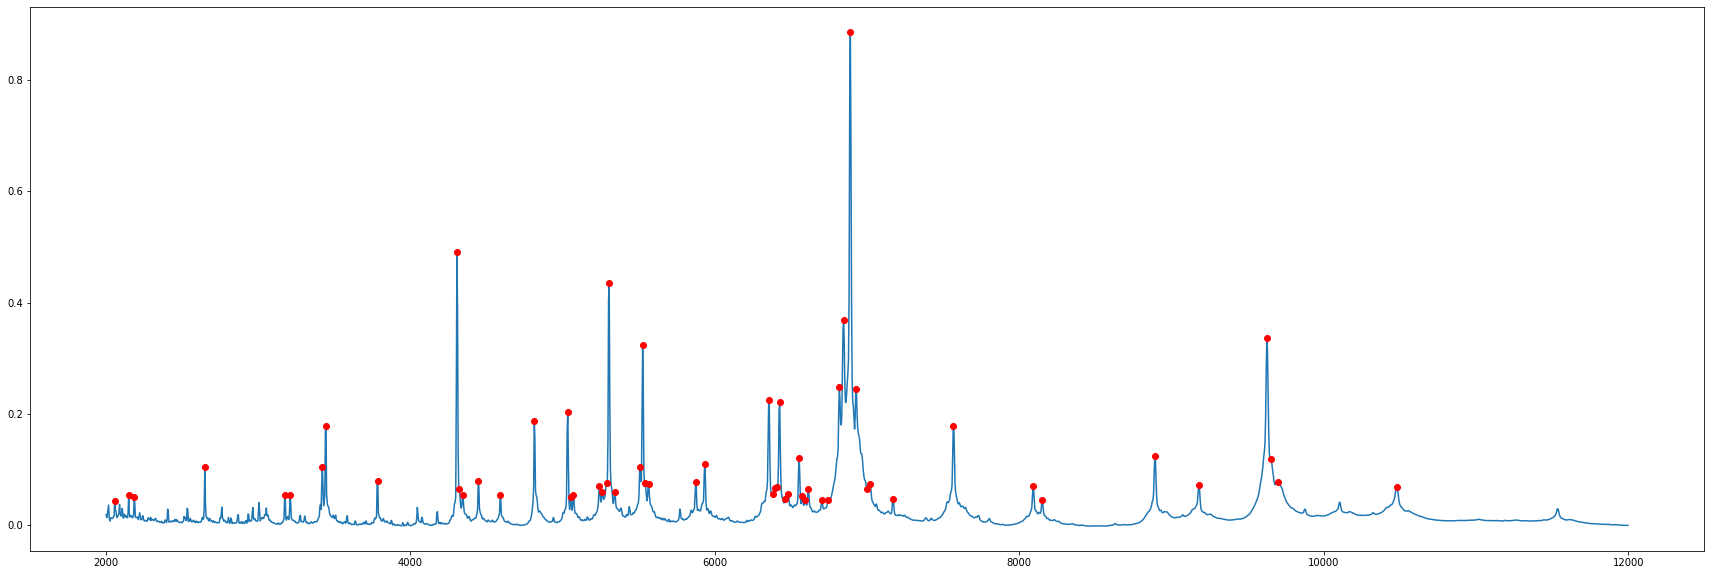

In [6]:
peaks = peakutils.peak.indexes(mean_spectrum,thres=0.05)

plt.figure(figsize=(30,10))
plt.plot(spectrum_train.columns.values,mean_spectrum)
plt.plot(spectrum_train.columns.values[peaks],mean_spectrum[peaks],'ro')
plt.show()

In [7]:
def spectrum_in_peaks(spectrum,peaks):
    df = spectrum.copy()
    spectrum  = spectrum.to_numpy()
    new_spectrum = np.zeros((spectrum.shape[0],len(peaks)))
    
    for i,x in enumerate(spectrum):
      spectrum_train_aux = x[peaks]
      new_spectrum[i,:] = spectrum_train_aux

    new_df = pd.DataFrame(data=new_spectrum, columns = df.columns.values[peaks], index = df.index)
    return new_df

peaks_spectrum_train = spectrum_in_peaks(spectrum_train, peaks)
peaks_spectrum_test_train = spectrum_in_peaks(spectrum_test_train, peaks)

## Low-area peak extraction
The idea is that most information may lie in the low area, but they are very low in amplitude, so they are not being detected right now. Therefore, let's get spectra in that area and attach those peaks to the other peaks. **For the moment, we will not bother with the fact that we will be normalizing by different values. Maybe later**

In [8]:
def spectrum_in_bins_4(df, m, M, bin_size): # first remove baseline and then normalization
    # Now, let's define the mz ranges, and the label associated to each of them (the mean of the limiting values of each bin)
    range_min = []; range_max = []; range_mean = []
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[0,i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins[0,:] -= peakutils.baseline(idx_data_in_bins[0,:],deg=4)
        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / np.max(idx_data_in_bins[0,:])
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)
    return new_df

In [9]:
spectrum_train_lowarea = spectrum_in_bins_4(data_train,2000,4000,2)
# spectrum_test_train_lowarea = spectrum_in_bins_3(data_test_train,2000,4000,2)
print('Spectrum interpolated!')

Spectrum interpolated!


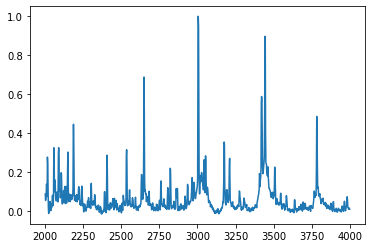

In [10]:
plt.plot(spectrum_train_lowarea.iloc[5,:])

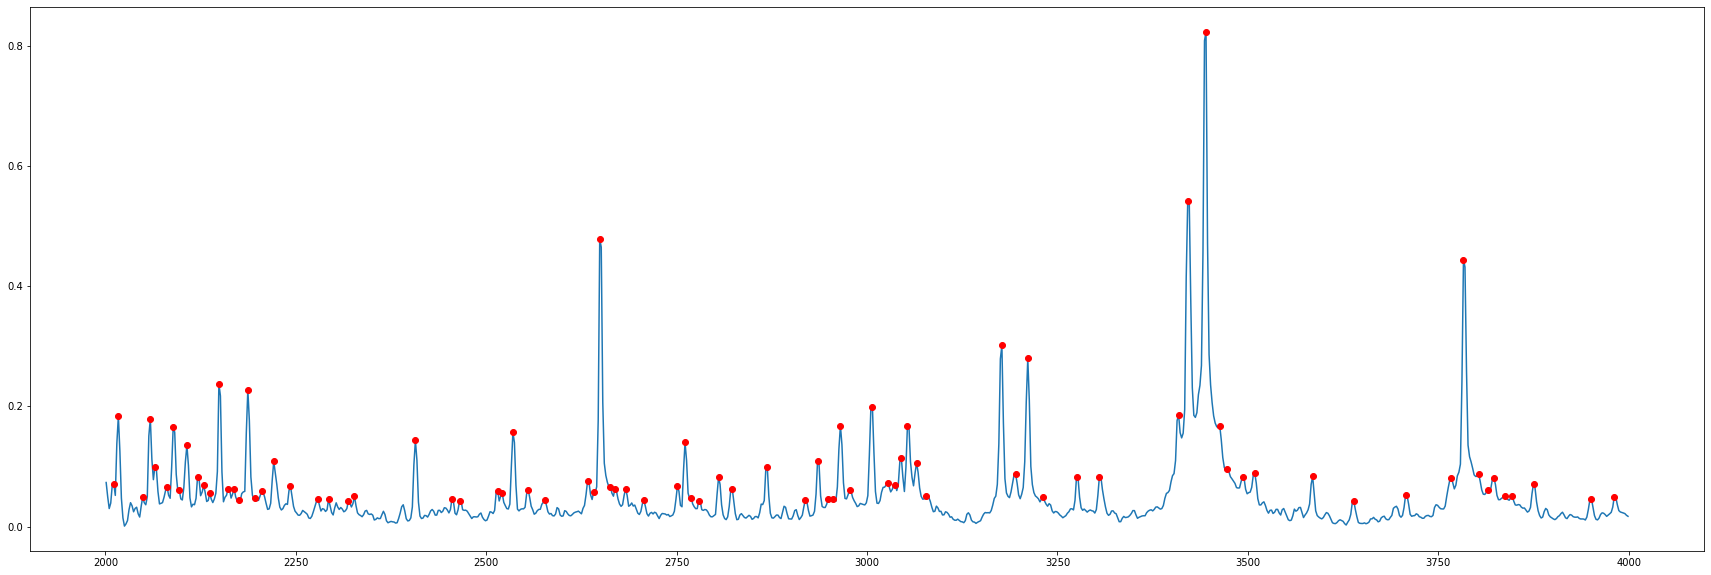

In [11]:
mean_spectrum_lowarea = np.mean(spectrum_train_lowarea.to_numpy(),axis=0)

peaks_lowarea = peakutils.peak.indexes(mean_spectrum_lowarea,thres=0.05)

plt.figure(figsize=(30,10))
plt.plot(spectrum_train_lowarea.columns.values,mean_spectrum_lowarea)
plt.plot(spectrum_train_lowarea.columns.values[peaks_lowarea],mean_spectrum_lowarea[peaks_lowarea],'ro')
plt.show()

In [12]:
peaks_spectrum_train_lowarea = spectrum_in_peaks(spectrum_train_lowarea,peaks_lowarea)

In [13]:
print(peaks_spectrum_train.shape)
peaks_spectrum_train.head()

(411, 58)


,2058,2150,2186,2650,3178,3210,3422,3446,3786,4306,...,7170,7566,8090,8150,8890,9178,9626,9650,9702,10478
ID,,,,,,,,,,,,,,,,,,,,,
297,0.029001,0.039038,0.036393,0.067914,0.047639,0.038483,0.077056,0.118296,0.057419,0.395430,...,0.035905,0.163055,0.064755,0.031946,0.108263,0.061626,0.274312,0.073776,0.053637,0.057139
311,0.134145,0.122495,0.147481,0.196382,0.136221,0.120991,0.252429,0.258000,0.217622,0.790086,...,0.106022,0.326981,0.158860,0.073664,0.268008,0.136372,0.466445,0.134648,0.097482,0.135182
298,0.024598,0.032559,0.029261,0.060990,0.040986,0.040132,0.079827,0.112490,0.043264,0.461703,...,0.052327,0.185261,0.097103,0.038135,0.121946,0.082002,0.261203,0.086458,0.068142,0.079406
71,0.043638,0.062986,0.054684,0.213435,0.078058,0.085562,0.161960,0.407008,0.137890,0.357558,...,0.048629,0.198355,0.070678,0.054898,0.142466,0.076793,0.479912,0.133504,0.081865,0.079425
170,0.005760,0.022680,0.008821,0.036699,0.082269,0.036116,0.092957,0.088497,0.079578,0.346567,...,0.053254,0.242473,0.074273,0.037982,0.111184,0.080732,0.396633,0.155965,0.104621,0.058637


In [14]:
print(peaks_spectrum_train_lowarea.shape)
peaks_spectrum_train_lowarea.head()

(411, 86)


,2011,2017,2049,2059,2065,2081,2089,2097,2107,2121,...,3767,3783,3803,3815,3823,3837,3847,3875,3951,3981
ID,,,,,,,,,,,,,,,,,,,,,
297,0.063771,0.046389,0.038063,0.191165,0.080693,0.050191,0.142419,0.040611,0.114436,0.039633,...,0.039043,0.485875,0.055075,0.039165,0.060969,0.042824,0.041248,0.045925,0.023235,0.021781
311,0.104424,0.143395,0.099035,0.454261,0.144909,0.104417,0.304297,0.065176,0.208008,0.062955,...,0.063134,0.804977,0.101257,0.077915,0.103232,0.052692,0.063942,0.036184,0.016227,0.030848
298,0.045259,0.153149,0.045419,0.152276,0.088376,0.071690,0.156243,0.051425,0.119673,0.095343,...,0.064065,0.483998,0.076430,0.056915,0.050687,0.053200,0.034361,0.103584,0.026000,0.047394
71,0.033458,0.044377,0.020370,0.099621,0.034336,0.030186,0.069721,0.029002,0.083791,0.022283,...,0.041982,0.334114,0.044231,0.025155,0.032354,0.027443,0.041569,0.035111,0.019618,0.037283
170,0.032900,0.101897,0.000433,0.019034,0.028231,0.051811,0.046985,0.020209,0.078310,0.046721,...,0.083584,0.378927,0.133157,0.090382,0.083101,0.046015,0.038816,0.107832,0.028852,0.028911


In [15]:
merged = pd.concat([peaks_spectrum_train,peaks_spectrum_train_lowarea],axis=1)

In [16]:
print(merged.shape)
merged.head()

(411, 144)


,2058,2150,2186,2650,3178,3210,3422,3446,3786,4306,...,3767,3783,3803,3815,3823,3837,3847,3875,3951,3981
ID,,,,,,,,,,,,,,,,,,,,,
297,0.029001,0.039038,0.036393,0.067914,0.047639,0.038483,0.077056,0.118296,0.057419,0.395430,...,0.039043,0.485875,0.055075,0.039165,0.060969,0.042824,0.041248,0.045925,0.023235,0.021781
311,0.134145,0.122495,0.147481,0.196382,0.136221,0.120991,0.252429,0.258000,0.217622,0.790086,...,0.063134,0.804977,0.101257,0.077915,0.103232,0.052692,0.063942,0.036184,0.016227,0.030848
298,0.024598,0.032559,0.029261,0.060990,0.040986,0.040132,0.079827,0.112490,0.043264,0.461703,...,0.064065,0.483998,0.076430,0.056915,0.050687,0.053200,0.034361,0.103584,0.026000,0.047394
71,0.043638,0.062986,0.054684,0.213435,0.078058,0.085562,0.161960,0.407008,0.137890,0.357558,...,0.041982,0.334114,0.044231,0.025155,0.032354,0.027443,0.041569,0.035111,0.019618,0.037283
170,0.005760,0.022680,0.008821,0.036699,0.082269,0.036116,0.092957,0.088497,0.079578,0.346567,...,0.083584,0.378927,0.133157,0.090382,0.083101,0.046015,0.038816,0.107832,0.028852,0.028911


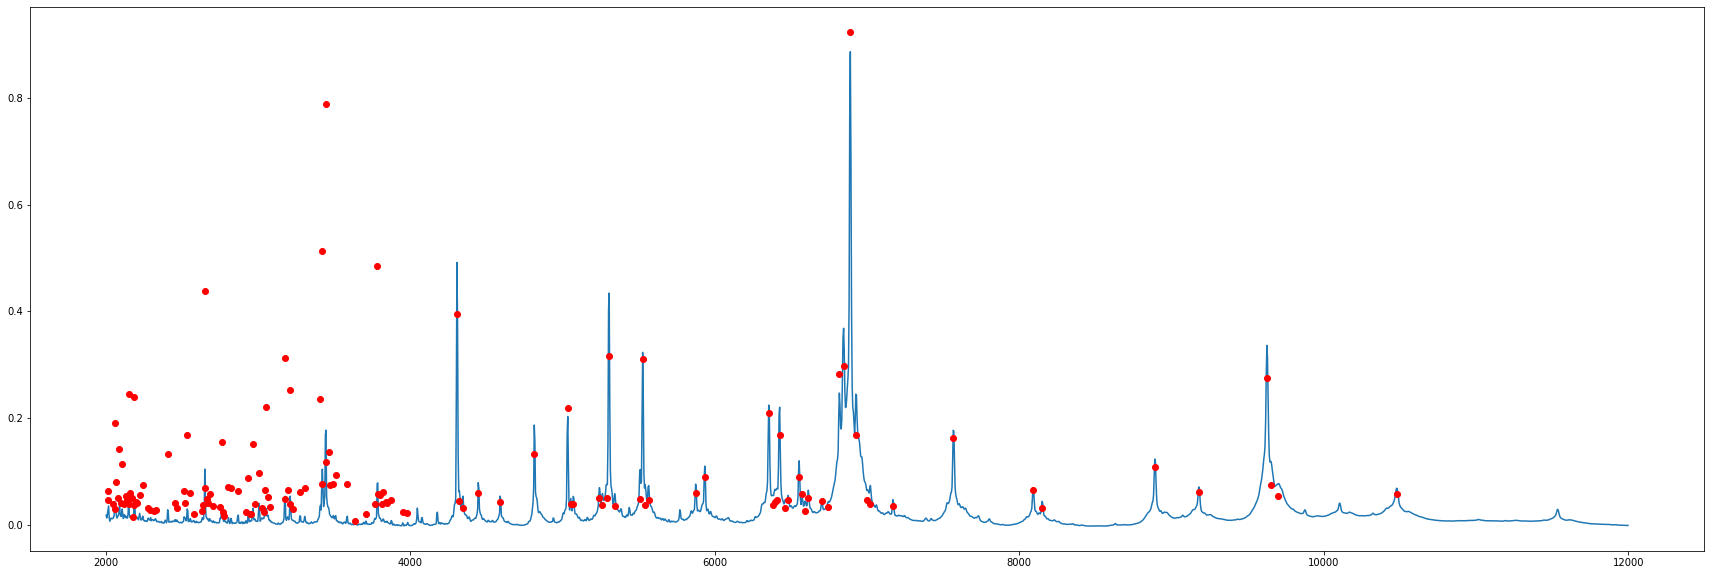

In [17]:
plt.figure(figsize=(30,10))
plt.plot(spectrum_train.columns.values,mean_spectrum)
plt.plot(merged.columns.values,merged.iloc[0,:],'ro')

## SVM
Now let's try with this new set of features (peaks) with a SVM.

In [18]:
spectrum_train_lowarea = spectrum_in_bins_4(data_train,2000,4000,2)
spectrum_test_train_lowarea = spectrum_in_bins_4(data_test_train,2000,4000,2)
print('Spectrum interpolated!')

Spectrum interpolated!


In [19]:
mean_spectrum_lowarea = np.mean(spectrum_train_lowarea.to_numpy(),axis=0)
peaks_lowarea = peakutils.peak.indexes(mean_spectrum_lowarea,thres=0.05)

peaks_spectrum_train_lowarea = spectrum_in_peaks(spectrum_train_lowarea,peaks_lowarea)
peaks_spectrum_test_train_lowarea = spectrum_in_peaks(spectrum_test_train_lowarea,peaks_lowarea)

merged_train = pd.concat([peaks_spectrum_train,peaks_spectrum_train_lowarea],axis=1)
merged_test_train = pd.concat([peaks_spectrum_test_train, peaks_spectrum_test_train_lowarea], axis=1)

In [20]:
def test_clf(df,n_fold,s_train, s_test_train, t_train, t_test_train, tuned_parameters):
  categories = df.columns[1:-2]
  clf_array =[]
  accuracy_array = []
  c_array =[]
  total_time = time.time()

  for c, cat in enumerate(categories): 
      start_time =time.time()
      X_train, Y_train = clean_nan_samples(s_train,t_train,c,cat)
      X_test, Y_test = clean_nan_samples(s_test_train,t_test_train,c,cat)
      clf  = GridSearchCV(SVC(class_weight='balanced', probability=True),iid=False,scoring='roc_auc',param_grid=tuned_parameters,
                        cv=n_fold, n_jobs = 3)
      clf.fit(X_train, Y_train)
      o_test = clf.predict_proba(X_test)[:,1]
      c_array.append(clf.best_params_)
      accuracy_array.append(roc_auc_score(Y_test,o_test))
      clf_array.append(clf)
      print(f'FINISHED {cat}, time{(time.time()-start_time)/60} minutes')

  print(f'Total time of execution: {(time.time() - total_time)/60} minutes')
  return clf_array, accuracy_array,c_array

In [21]:
from sklearn.svm import SVC
params = {'C':[0.1,0.5,1,5,10,20],'kernel':['linear']}
clf_array, accuracy_array_merged,c_array = test_clf(df_train, 3, merged_train, merged_test_train, targets_train, targets_test_train, params)

FINISHED OXACILINA, time0.05208297570546468 minutes
FINISHED AMIKACINA, time0.00937498410542806 minutes
FINISHED AMOXI/CLAV, time0.01171872615814209 minutes
FINISHED CIPROFLOXACINO, time0.011979138851165772 minutes
FINISHED CLINDAMICINA, time0.013020761807759603 minutes
FINISHED ERITROMICINA, time0.013802043596903483 minutes
FINISHED LEVOFLOXACINO, time0.011979174613952637 minutes
FINISHED PENICILINA, time0.010677377382914225 minutes
FINISHED TOBRAMICINA, time0.009374650319417317 minutes
Total time of execution: 0.14400983254114788 minutes


In [22]:
# and without merging
clf_array, accuracy_array,c_array = test_clf(df_train, 3, peaks_spectrum_train, peaks_spectrum_test_train, targets_train, targets_test_train, params)

FINISHED OXACILINA, time0.006770781675974528 minutes
FINISHED AMIKACINA, time0.0072912971178690595 minutes
FINISHED AMOXI/CLAV, time0.007292004426320394 minutes
FINISHED CIPROFLOXACINO, time0.007551745573679606 minutes
FINISHED CLINDAMICINA, time0.006770817438761393 minutes
FINISHED ERITROMICINA, time0.007552059491475424 minutes
FINISHED LEVOFLOXACINO, time0.0070312261581420895 minutes
FINISHED PENICILINA, time0.006250313917795817 minutes
FINISHED TOBRAMICINA, time0.00729128917058309 minutes
Total time of execution: 0.0638015349706014 minutes


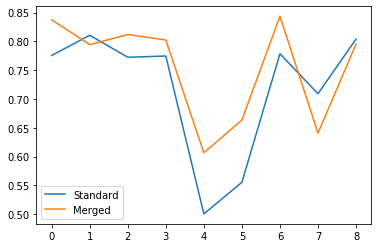

In [23]:
plt.plot(accuracy_array,label='Standard')
plt.plot(accuracy_array_merged,label='Merged')
plt.legend(); plt.show()

Now, let's take into account the normalization constant, using the same for both parts of the spectrum:

In [35]:
def peaks_spectrums(df, m_lowarea, M_lowarea, bin_size_lowarea, m, M, bin_size): 
    
    # SPECTRUM IN BINS FOR NORMAL RANGE
    range_min = []; range_max = []; range_mean = []
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
           
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    normaliz_cst = np.zeros((N,))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[0,i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins[0,:] -= peakutils.baseline(idx_data_in_bins[0,:],deg=4)
        # Normalize the amplitude of the spectrum
        normaliz_cst[idx] = np.max(idx_data_in_bins[0,:])
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / normaliz_cst[idx]
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)   
    
    
    # VERY SIMILAR CODE FOR "LOW AREA"
    range_min_lowarea = []; range_max_lowarea = []; range_mean_lowarea = []
    for mz in range(m_lowarea,M_lowarea,bin_size_lowarea):
        range_min_lowarea.append(mz)
        range_max_lowarea.append(mz+bin_size_lowarea)
        range_mean_lowarea.append(np.mean([range_min_lowarea[-1],range_max_lowarea[-1]]).astype(int))
    N = len(df)  # number of samples
    L = len(range_min_lowarea)  # length of new spectrum (number of bins)
    all_data_lowarea = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min_lowarea):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size_lowarea))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[0,i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins[0,:] -= peakutils.baseline(idx_data_in_bins[0,:],deg=4)
        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / normaliz_cst[idx] # same normaliz_cst than on the other part of the spectrum
        # Store in matrix
        all_data_lowarea[idx,:] = idx_data_in_bins
    new_df_lowarea = pd.DataFrame(data=all_data_lowarea, columns = range_mean_lowarea, index = df.index)

    return new_df, new_df_lowarea

In [36]:
spectrum_train, spectrum_train_lowarea = merged_peaks_spectrums(data_train, 2000, 4000, 2, m, M, bin_size)
spectrum_test_train, spectrum_test_train_lowarea = merged_peaks_spectrums(data_test_train, 2000, 4000, 2, m, M, bin_size)

threshold = 0.05
threshold_lowarea = 0.05

# get general spectrum, and their peaks
mean_spectrum = np.mean(spectrum_train.to_numpy(),axis=0)
peaks = peakutils.peak.indexes(mean_spectrum,thres=threshold)
peaks_spectrum_train = spectrum_in_peaks(spectrum_train, peaks)  
peaks_spectrum_test_train = spectrum_in_peaks(spectrum_test_train, peaks)  
print()

# get lowarea spectrum and peaks
mean_spectrum_lowarea = np.mean(spectrum_train_lowarea.to_numpy(),axis=0)
peaks_lowarea = peakutils.peak.indexes(mean_spectrum_lowarea,thres=threshold_lowarea)
peaks_spectrum_train_lowarea = spectrum_in_peaks(spectrum_train_lowarea, peaks_lowarea) 
peaks_spectrum_test_train_lowarea = spectrum_in_peaks(spectrum_test_train_lowarea, peaks_lowarea)

# merge both
merged_train = pd.concat([peaks_spectrum_train,peaks_spectrum_train_lowarea],axis=1)
merged_test_train = pd.concat([peaks_spectrum_test_train,peaks_spectrum_test_train_lowarea],axis=1)

In [37]:
from sklearn.svm import SVC
params = {'C':[0.1,0.5,1,5,10,20],'kernel':['linear']}
clf_array, accuracy_array_merged_new,c_array = test_clf(df_train, 3, merged_train, merged_test_train, targets_train, targets_test_train, params)

FINISHED OXACILINA, time0.050520714124043783 minutes
FINISHED AMIKACINA, time0.010155872503916422 minutes
FINISHED AMOXI/CLAV, time0.011198198795318604 minutes
FINISHED CIPROFLOXACINO, time0.011718440055847167 minutes
FINISHED CLINDAMICINA, time0.011718662579854329 minutes
FINISHED ERITROMICINA, time0.01302114725112915 minutes
FINISHED LEVOFLOXACINO, time0.012239225705464681 minutes
FINISHED PENICILINA, time0.011458297570546469 minutes
FINISHED TOBRAMICINA, time0.010677027702331542 minutes
Total time of execution: 0.14270758628845215 minutes


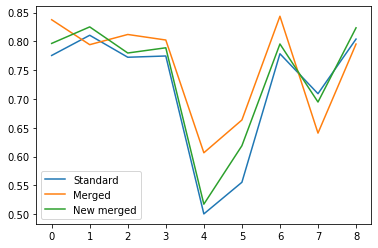

In [38]:
plt.plot(accuracy_array,label='Standard')
plt.plot(accuracy_array_merged,label='Merged')
plt.plot(accuracy_array_merged_new,label='New merged')
plt.legend(); plt.show()

# sentaba bien que esos picos tuviesen más amplitud. Probar con GPs para los tres, a ver si influye o no.
# meter un parametro en la funcion de si quieres que divida por normaliz_cst o no (por la del intervalo lowarea)

In [39]:
def peaks_spectrums(df, m_lowarea, M_lowarea, bin_size_lowarea, m, M, bin_size, SAME_NORMALIZATION=False): 
    t1 = time.time()
    # SPECTRUM IN BINS FOR NORMAL RANGE
    range_min = []; range_max = []; range_mean = []
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
           
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    normaliz_cst = np.zeros((N,))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[0,i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins[0,:] -= peakutils.baseline(idx_data_in_bins[0,:],deg=4)
        # Normalize the amplitude of the spectrum
        normaliz_cst[idx] = np.max(idx_data_in_bins[0,:])
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / normaliz_cst[idx]
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)   
    
    t2 = time.time()
    print(t2-t1)
    # VERY SIMILAR CODE FOR "LOW AREA"
    range_min_lowarea = []; range_max_lowarea = []; range_mean_lowarea = []
    for mz in range(m_lowarea,M_lowarea,bin_size_lowarea):
        range_min_lowarea.append(mz)
        range_max_lowarea.append(mz+bin_size_lowarea)
        range_mean_lowarea.append(np.mean([range_min_lowarea[-1],range_max_lowarea[-1]]).astype(int))
    N = len(df)  # number of samples
    L = len(range_min_lowarea)  # length of new spectrum (number of bins)
    all_data_lowarea = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((L,))
        for i,mz in enumerate(range_min_lowarea):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size_lowarea))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins -= peakutils.baseline(idx_data_in_bins,deg=4)
        # Normalize the amplitude of the spectrum
        if SAME_NORMALIZATION:
            idx_data_in_bins = idx_data_in_bins / normaliz_cst[idx] # same normaliz_cst than on the other part of the spectrum
        else:
            idx_data_in_bins = idx_data_in_bins / np.max(idx_data_in_bins)
        # Store in matrix
        all_data_lowarea[idx,:] = idx_data_in_bins.reshape(1,-1)
    new_df_lowarea = pd.DataFrame(data=all_data_lowarea, columns = range_mean_lowarea, index = df.index)
    t3 = time.time()
    print(t3-t2)
    return new_df, new_df_lowarea

In [41]:
spectrum_test_train, spectrum_test_train_lowarea = peaks_spectrums(data_test_train, 2000, 4000, 2, m, M, bin_size, False)

14.859332084655762
6.15623140335083


In [62]:
def binned_spectrums_lowarea(df, m_lowarea, M_lowarea, bin_size_lowarea, m, M, bin_size, SAME_NORMALIZATION=False): 

    # SPECTRUM IN BINS FOR NORMAL RANGE
    range_min = []; range_max = []; range_mean = []
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
           
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    normaliz_cst = np.zeros((N,))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((L,))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins -= peakutils.baseline(idx_data_in_bins,deg=4)
        # Normalize the amplitude of the spectrum
        normaliz_cst[idx] = np.max(idx_data_in_bins)
        idx_data_in_bins = idx_data_in_bins / normaliz_cst[idx]
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins.reshape(1,-1)
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)  
    
    # VERY SIMILAR CODE FOR "LOW AREA"
    range_min_lowarea = []; range_max_lowarea = []; range_mean_lowarea = []
    for mz in range(m_lowarea,M_lowarea,bin_size_lowarea):
        range_min_lowarea.append(mz)
        range_max_lowarea.append(mz+bin_size_lowarea)
        range_mean_lowarea.append(np.mean([range_min_lowarea[-1],range_max_lowarea[-1]]).astype(int))
    N = len(df)  # number of samples
    L = len(range_min_lowarea)  # length of new spectrum (number of bins)
    all_data_lowarea = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((L,))
        for i,mz in enumerate(range_min_lowarea):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size_lowarea))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[i] = np.interp(x=range_mean[i],xp=mzcoord,fp=intensity)

        # Remove baseline
        idx_data_in_bins -= peakutils.baseline(idx_data_in_bins,deg=4)
        # Normalize the amplitude of the spectrum
        if SAME_NORMALIZATION:
            idx_data_in_bins = idx_data_in_bins / normaliz_cst[idx] # same normaliz_cst than on the other part of the spectrum
        else:
            idx_data_in_bins = idx_data_in_bins / np.max(idx_data_in_bins)
        # Store in matrix
        all_data_lowarea[idx,:] = idx_data_in_bins.reshape(1,-1)
    new_df_lowarea = pd.DataFrame(data=all_data_lowarea, columns = range_mean_lowarea, index = df.index)

    return new_df, new_df_lowarea

In [51]:
spectrum_test_train, spectrum_test_train_lowarea = peaks_spectrums(data_test_train, 2000, 4000, 2, m, M, bin_size, False)

[ 8914.92615676 41268.00196434 28395.5399196  42098.09086536
 21254.55768062 51743.20050515  6900.68019735 44167.00698562
  5768.78247656 22925.12723483 49328.13826121 38368.82099633
 53754.55877559 57049.2201579  43052.71195919 39986.69647848
 22572.68951472 19543.86022635  7050.76964946 36908.07768654
 57242.18313165 42446.83611001 45617.71723916 15065.6334712
 30584.23459189 31045.31311641 39964.8605286  28605.71502529
 35989.31854814  3162.48525081 13768.70335037 33322.52130328
 29483.44399553 50022.24048871 26238.48845684 14666.9313597
 16479.88831188 25328.44356573 12222.15591754  1495.93960781
 24551.93953506 42215.57904995  1433.83168937 40028.34886134
 31588.39381763 18240.22194816 41844.20543404 34337.73774317
 25681.80766047 20521.06947361 11265.81891131 43641.98328298
 42168.15221608 41352.90495706 30205.23396731  5687.20781624
 36544.67704922 28953.1992467  39183.13177959 37648.35043308
 44034.16108799 10662.69348034 25187.01090801 43537.82421151
 35928.0882807  20591.9922

### Different normalization

In [56]:
spectrum_train, spectrum_train_lowarea = peaks_spectrums(data_train, 2000, 4000, 2, m, M, bin_size, False)
spectrum_test_train, spectrum_test_train_lowarea = peaks_spectrums(data_test_train, 2000, 4000, 2, m, M, bin_size, False)

threshold = 0.05
threshold_lowarea = 0.05

# get general spectrum, and their peaks
mean_spectrum = np.mean(spectrum_train.to_numpy(),axis=0)
peaks = peakutils.peak.indexes(mean_spectrum,thres=threshold)
peaks_spectrum_train = spectrum_in_peaks(spectrum_train, peaks)  
peaks_spectrum_test_train = spectrum_in_peaks(spectrum_test_train, peaks)  
print('General spectrum DONE')

# get lowarea spectrum and peaks
mean_spectrum_lowarea = np.mean(spectrum_train_lowarea.to_numpy(),axis=0)
peaks_lowarea = peakutils.peak.indexes(mean_spectrum_lowarea,thres=threshold_lowarea)
peaks_spectrum_train_lowarea = spectrum_in_peaks(spectrum_train_lowarea, peaks_lowarea) 
peaks_spectrum_test_train_lowarea = spectrum_in_peaks(spectrum_test_train_lowarea, peaks_lowarea)
print('Low area spectrum DONE')

# merge both
merged_train = pd.concat([peaks_spectrum_train,peaks_spectrum_train_lowarea],axis=1)
merged_test_train = pd.concat([peaks_spectrum_test_train,peaks_spectrum_test_train_lowarea],axis=1)
print('Merging DONE')

[32659.4559725  32056.82834176 24702.43993248 55207.8157894
  8814.43028401 34249.60496288 44768.91381514 49976.65646853
 18122.23010457 32086.99467675  7599.15879858 35634.35185212
 51752.80392235 48861.86100271 56886.37309773 39098.98893981
 47274.75248965 32656.94367188 25428.59060059 14029.70982523
 12612.09377425 42189.28049809 39615.38973462 28375.67238491
 34762.55011093 30915.08272047 22141.61623617 33439.53086314
 50604.04355519 37496.37336947 39401.96771098 37920.50660634
 53629.8247625  49344.73940399 20424.7312856  42463.97821841
 16383.56054067 47305.89892732  3906.87481192 30246.89755825
 34537.5030872  50964.31794652 21236.34592417 16879.28704967
 43634.30052465 17188.11308804 31409.2092225  36435.61106551
 34691.17980159  5285.03613111 48507.50314942 28393.69399723
 19709.87642565 39698.89012581  1670.92043042 35888.57794066
 31811.2341028  16933.05814183  5093.4505777  33491.6644943
 20658.48680396 54871.19039877 17610.05080943 20036.02827702
 15884.06646191 29875.2135

In [57]:
params = {'C':[0.1,0.5,1,5,10,20],'kernel':['linear']}
clf_array, auc_diff_norm, c_array = test_clf(df_train, 3, merged_train, merged_test_train, targets_train, targets_test_train, params)

FINISHED OXACILINA, time0.013281206289927164 minutes
FINISHED AMIKACINA, time0.010156214237213135 minutes
FINISHED AMOXI/CLAV, time0.01354200839996338 minutes
FINISHED CIPROFLOXACINO, time0.012499574820200603 minutes
FINISHED CLINDAMICINA, time0.01328127384185791 minutes
FINISHED ERITROMICINA, time0.014583269755045572 minutes
FINISHED LEVOFLOXACINO, time0.013020769755045573 minutes
FINISHED PENICILINA, time0.010937809944152832 minutes
FINISHED TOBRAMICINA, time0.01041633685429891 minutes
Total time of execution: 0.11171846389770508 minutes


### Same normalization

In [63]:
spectrum_train, spectrum_train_lowarea = peaks_spectrums(data_train, 2000, 4000, 2, m, M, bin_size, True)
spectrum_test_train, spectrum_test_train_lowarea = peaks_spectrums(data_test_train, 2000, 4000, 2, m, M, bin_size, True)

threshold = 0.05
threshold_lowarea = 0.05

# get general spectrum, and their peaks
mean_spectrum = np.mean(spectrum_train.to_numpy(),axis=0)
peaks = peakutils.peak.indexes(mean_spectrum,thres=threshold)
peaks_spectrum_train = spectrum_in_peaks(spectrum_train, peaks)  
peaks_spectrum_test_train = spectrum_in_peaks(spectrum_test_train, peaks)  
print('General spectrum DONE')

# get lowarea spectrum and peaks
mean_spectrum_lowarea = np.mean(spectrum_train_lowarea.to_numpy(),axis=0)
peaks_lowarea = peakutils.peak.indexes(mean_spectrum_lowarea,thres=threshold_lowarea)
peaks_spectrum_train_lowarea = spectrum_in_peaks(spectrum_train_lowarea, peaks_lowarea) 
peaks_spectrum_test_train_lowarea = spectrum_in_peaks(spectrum_test_train_lowarea, peaks_lowarea)
print('Low area spectrum DONE')

# merge both
merged_train = pd.concat([peaks_spectrum_train,peaks_spectrum_train_lowarea],axis=1)
merged_test_train = pd.concat([peaks_spectrum_test_train,peaks_spectrum_test_train_lowarea],axis=1)
print('Merging DONE')

General spectrum DONE
Low area spectrum DONE
Merging DONE


In [64]:
params = {'C':[0.1,0.5,1,5,10,20],'kernel':['linear']}
clf_array, auc_same_norm, c_array = test_clf(df_train, 3, merged_train, merged_test_train, targets_train, targets_test_train, params)

FINISHED OXACILINA, time0.01249999205271403 minutes
FINISHED AMIKACINA, time0.011197908719380697 minutes
FINISHED AMOXI/CLAV, time0.01484369436899821 minutes
FINISHED CIPROFLOXACINO, time0.013020805517832438 minutes
FINISHED CLINDAMICINA, time0.01328119436899821 minutes
FINISHED ERITROMICINA, time0.014583345254262288 minutes
FINISHED LEVOFLOXACINO, time0.013801999886830648 minutes
FINISHED PENICILINA, time0.01328123410542806 minutes
FINISHED TOBRAMICINA, time0.011458281675974529 minutes
Total time of execution: 0.11822883685429891 minutes


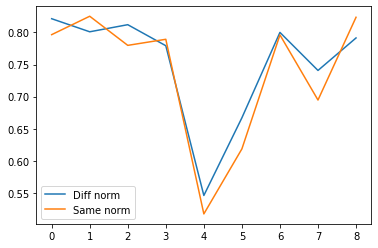

In [65]:
plt.plot(auc_diff_norm,label='Diff norm')
plt.plot(auc_same_norm,label='Same norm')
plt.legend(); plt.show();

It looks pretty well. Nevertheless, we should reduce dimensionality, at least for GPs. So let's use PCA, that seems easier to work with:

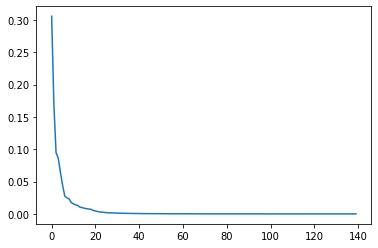

In [67]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(merged_train)
plt.plot(pca.explained_variance_ratio_)

In [70]:
VAF = pca.explained_variance_ratio_
print(np.sum(VAF[0:20]))
print(np.sum(VAF[0:30]))

0.956739914289762
0.9811026564533886


Just with 30 features we are keeping 98% of variance (and therefore, supposedly, of information). Therefore, let's try that:

In [81]:
pca = PCA(n_components=20)
new_merged_train = pca.fit_transform(merged_train)
new_merged_test_train = pca.transform(merged_test_train)

new_merged_train = pd.DataFrame(data=new_merged_train, index = merged_train.index)
new_merged_test_train = pd.DataFrame(data=new_merged_test_train, index = merged_test_train.index)

params = {'C':[0.1,0.5,1,5,10,20],'kernel':['linear']}
clf_array, auc_pca20, c_array = test_clf(df_train, 3, new_merged_train, new_merged_test_train, targets_train, targets_test_train, params)

FINISHED OXACILINA, time0.006250301996866862 minutes
FINISHED AMIKACINA, time0.0046871344248453775 minutes
FINISHED AMOXI/CLAV, time0.004947956403096517 minutes
FINISHED CIPROFLOXACINO, time0.006770789623260498 minutes
FINISHED CLINDAMICINA, time0.0059899131457010904 minutes
FINISHED ERITROMICINA, time0.006510376930236816 minutes
FINISHED LEVOFLOXACINO, time0.0067705512046813965 minutes
FINISHED PENICILINA, time0.00546864668528239 minutes
FINISHED TOBRAMICINA, time0.0057291428248087565 minutes
Total time of execution: 0.053124813238779704 minutes


In [82]:
pca = PCA(n_components=30)
new_merged_train = pca.fit_transform(merged_train)
new_merged_test_train = pca.transform(merged_test_train)

new_merged_train = pd.DataFrame(data=new_merged_train, index = merged_train.index)
new_merged_test_train = pd.DataFrame(data=new_merged_test_train, index = merged_test_train.index)

params = {'C':[0.1,0.5,1,5,10,20],'kernel':['linear']}
clf_array, auc_pca30, c_array = test_clf(df_train, 3, new_merged_train, new_merged_test_train, targets_train, targets_test_train, params)

FINISHED OXACILINA, time0.0057291309038798015 minutes
FINISHED AMIKACINA, time0.005208667119344076 minutes
FINISHED AMOXI/CLAV, time0.006770817438761393 minutes
FINISHED CIPROFLOXACINO, time0.0067708373069763185 minutes
FINISHED CLINDAMICINA, time0.007030868530273437 minutes
FINISHED ERITROMICINA, time0.00624998410542806 minutes
FINISHED LEVOFLOXACINO, time0.006250333786010742 minutes
FINISHED PENICILINA, time0.005989559491475423 minutes
FINISHED TOBRAMICINA, time0.005468432108561198 minutes
Total time of execution: 0.055468630790710446 minutes


In [83]:
pca = PCA(n_components=50)
new_merged_train = pca.fit_transform(merged_train)
new_merged_test_train = pca.transform(merged_test_train)

new_merged_train = pd.DataFrame(data=new_merged_train, index = merged_train.index)
new_merged_test_train = pd.DataFrame(data=new_merged_test_train, index = merged_test_train.index)

params = {'C':[0.1,0.5,1,5,10,20],'kernel':['linear']}
clf_array, auc_pca50, c_array = test_clf(df_train, 3, new_merged_train, new_merged_test_train, targets_train, targets_test_train, params)

FINISHED OXACILINA, time0.007292040189107259 minutes
FINISHED AMIKACINA, time0.0078120589256286625 minutes
FINISHED AMOXI/CLAV, time0.007292012373606364 minutes
FINISHED CIPROFLOXACINO, time0.00781249205271403 minutes
FINISHED CLINDAMICINA, time0.007291285196940104 minutes
FINISHED ERITROMICINA, time0.00859372615814209 minutes
FINISHED LEVOFLOXACINO, time0.008333313465118408 minutes
FINISHED PENICILINA, time0.006510734558105469 minutes
FINISHED TOBRAMICINA, time0.006770805517832438 minutes
Total time of execution: 0.06770846843719483 minutes


In [88]:
pca = PCA(n_components=80)
new_merged_train = pca.fit_transform(merged_train)
new_merged_test_train = pca.transform(merged_test_train)

new_merged_train = pd.DataFrame(data=new_merged_train, index = merged_train.index)
new_merged_test_train = pd.DataFrame(data=new_merged_test_train, index = merged_test_train.index)

params = {'C':[0.1,0.5,1,5,10,20],'kernel':['linear']}
clf_array, auc_pca80, c_array = test_clf(df_train, 3, new_merged_train, new_merged_test_train, targets_train, targets_test_train, params)

FINISHED OXACILINA, time0.008333329359690349 minutes
FINISHED AMIKACINA, time0.007291650772094727 minutes
FINISHED AMOXI/CLAV, time0.00911488135655721 minutes
FINISHED CIPROFLOXACINO, time0.009895543257395426 minutes
FINISHED CLINDAMICINA, time0.0075519800186157225 minutes
FINISHED ERITROMICINA, time0.010416626930236816 minutes
FINISHED LEVOFLOXACINO, time0.008854142824808757 minutes
FINISHED PENICILINA, time0.007031261920928955 minutes
FINISHED TOBRAMICINA, time0.00781247615814209 minutes
Total time of execution: 0.07656230131785074 minutes


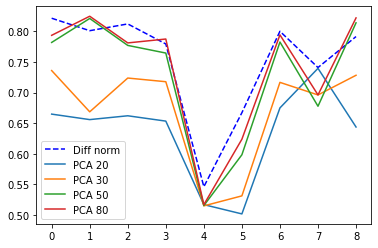

In [89]:
plt.plot(auc_diff_norm,'b--',label='Diff norm')
# plt.plot(auc_same_norm,label='Same norm')
plt.plot(auc_pca20,label='PCA 20')
plt.plot(auc_pca30,label='PCA 30')
plt.plot(auc_pca50,label='PCA 50')
plt.plot(auc_pca80,label='PCA 80')
plt.legend(); plt.show();

Ok, PCA does not seem the way to go. As Jesus says, taking out information is not helping at all.